In [ ]:
import os
import numpy as np
import pydicom
import nibabel as nib
from PIL import Image

# --- CONFIG ---
ct_dicom_dir = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest/train/images/patient_0001/exam_1'
mask_png_dir = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest/train/masks/patient_0001/exam_1'
output_dir = './output_nifti'
os.makedirs(output_dir, exist_ok=True)

# --- STEP 1: Load DICOM slices ---
dicom_files = sorted([f for f in os.listdir(ct_dicom_dir) if f.endswith('.dcm')])
dicom_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))  # sort by slice number

ct_slices = []
for f in dicom_files:
    ds = pydicom.dcmread(os.path.join(ct_dicom_dir, f))
    ct_slices.append(ds.pixel_array)

ct_volume = np.stack(ct_slices, axis=-1)
print(f"CT volume shape: {ct_volume.shape}")

# --- STEP 2: Build empty mask volume ---
mask_volume = np.zeros_like(ct_volume, dtype=np.uint8)

# --- STEP 3: Insert available PNG masks ---
for png_file in os.listdir(mask_png_dir):
    if png_file.endswith('.png'):
        parts = png_file.split('_')
        slice_idx = int(parts[-1].replace('mask.png', '')) - 1  # make it 0-based index
        mask_path = os.path.join(mask_png_dir, png_file)
        mask_img = np.array(Image.open(mask_path).convert('L'))  # grayscale
        mask_bin = (mask_img > 0).astype(np.uint8)  # binarize
        mask_volume[:, :, slice_idx] = mask_bin

print(f"Mask volume shape: {mask_volume.shape}")

# --- STEP 4: Save as NIfTI ---
affine = np.eye(4)  # optionally, you can pull affine from DICOM metadata

ct_nifti = nib.Nifti1Image(ct_volume, affine)
mask_nifti = nib.Nifti1Image(mask_volume, affine)

nib.save(ct_nifti, os.path.join(output_dir, 'ct_volume.nii.gz'))
nib.save(mask_nifti, os.path.join(output_dir, 'mask_volume.nii.gz'))

print("Saved NIfTI files to:", output_dir)


In [ ]:
import os
import pandas as pd
import numpy as np
import pydicom
import SimpleITK as sitk
from PIL import Image

# Input CSV file (adjust this to your CSV filename)
csv_file      = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest/train/train_dataset.csv'
# Base directories
base_ct_dir   = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest/train/images'
base_mask_dir = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest/train/masks'
Save_Dir_ct   = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest_nifti_ct/'
Save_Dir_mask = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest_nifti_mask/'

#--- Dataframe
df      = pd.read_csv(csv_file)
# Group by patient and exam
grouped = df.groupby(['patientID', 'exam'])

for (patient_id, exam_id), group in grouped:
    print(f"Processing patient {patient_id}, exam {exam_id}")
    
    # Sort slices
    group_sorted = group.sort_values('slice')
    
    # Read DICOM slices
    ct_slices = []
    for idx, row in group_sorted.iterrows():
        dcm_path = os.path.join(base_ct_dir, row['image'])
        ds = pydicom.dcmread(dcm_path)
        ct_slices.append(ds.pixel_array)
    
    ct_volume = np.stack(ct_slices, axis=0)
    ct_image = sitk.GetImageFromArray(ct_volume)
    
    # Set spacing (if available from DICOM)
    ds0 = pydicom.dcmread(os.path.join(base_ct_dir, group_sorted.iloc[0]['image']))
    spacing = [float(ds0.PixelSpacing[0]), float(ds0.PixelSpacing[1]), float(ds0.SliceThickness)]
    ct_image.SetSpacing(spacing)
    
    # Prepare mask volume
    mask_slices = []
    for idx, row in group_sorted.iterrows():
        if pd.notna(row['mask']):
            mask_path = os.path.join(base_mask_dir, row['mask'])
            mask_img = Image.open(mask_path).convert('L')
            mask_array = np.array(mask_img) > 0  # binary mask
        else:
            # Empty slice
            mask_array = np.zeros_like(ct_slices[0], dtype=np.uint8)
        mask_slices.append(mask_array.astype(np.uint8))
    
    mask_volume = np.stack(mask_slices, axis=0)
    mask_image = sitk.GetImageFromArray(mask_volume)
    mask_image.SetSpacing(spacing)
    
    # Save NIfTI files
    output_ct_path   = Save_Dir_ct   + f"unitochestPT{patient_id}_exam{exam_id}_0000.nii.gz"
    output_mask_path = Save_Dir_mask + f"unitochestPT{patient_id}_exam{exam_id}_mask.nii.gz"
    sitk.WriteImage(ct_image, output_ct_path)
    sitk.WriteImage(mask_image, output_mask_path)
    print(f"Saved: {output_ct_path}, {output_mask_path}")




# Anlyze dataset

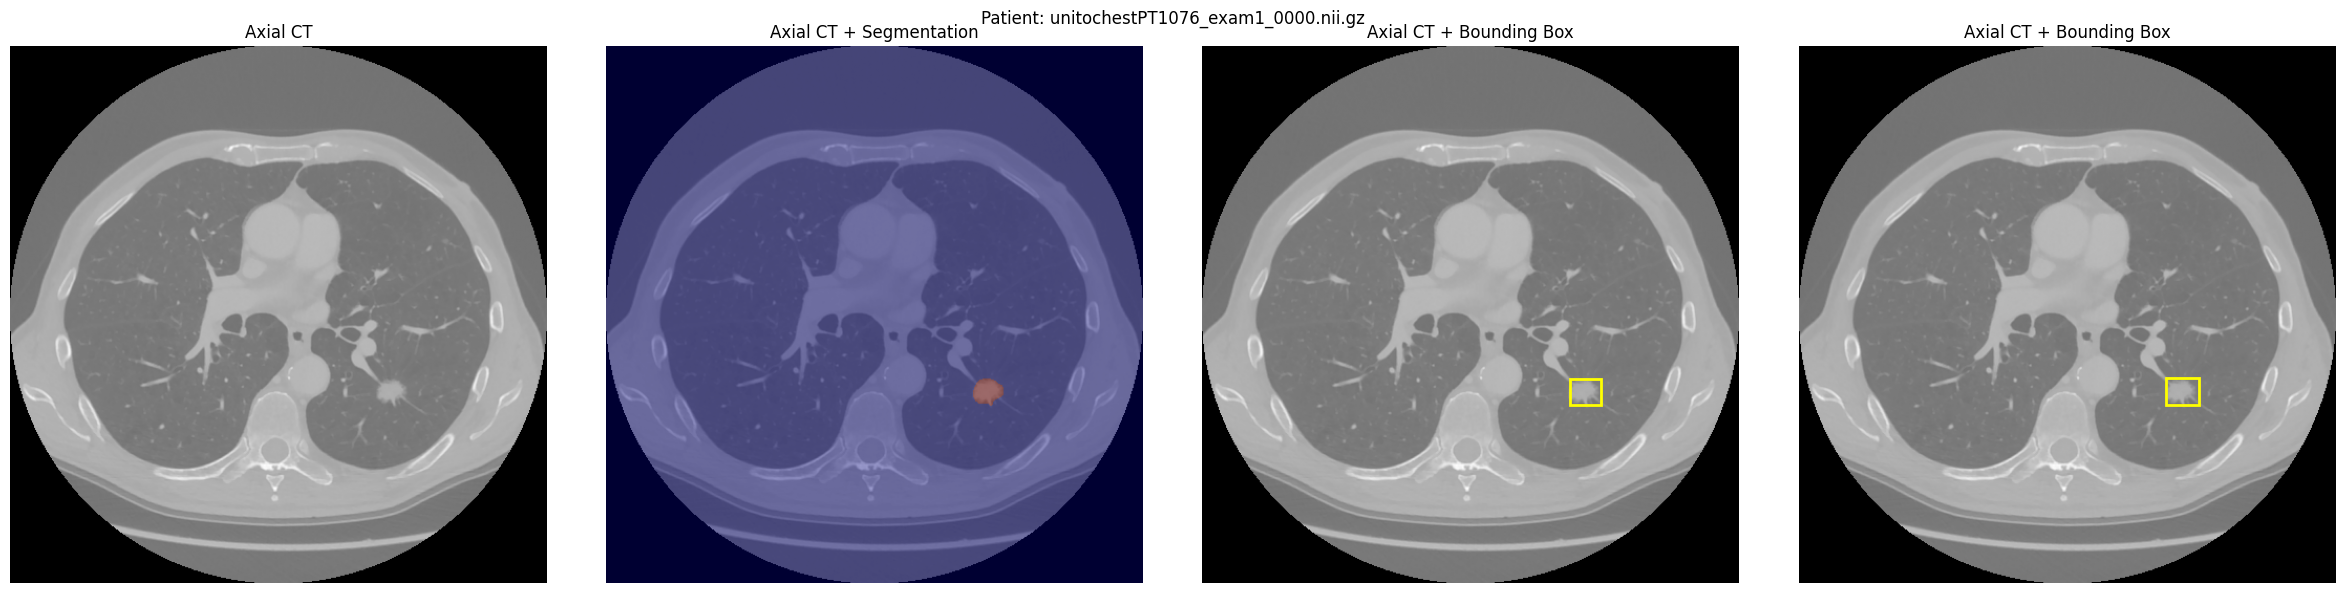

In [8]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import os
#import cv2
import csv
import json
import math
import random
import numpy as np
import pandas as pd
from PIL import Image
import SimpleITK as sitk
from skimage import filters
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
random.seed(200)

# Prepare CSV storage
bounding_boxes = []
MARGIN_OF_BOX_GRACE = 1
EXCLUDING_TINY_BOXEX_MARGIN = 1
GUASSIAN_SMOOTHING_SIGMA = 1.2
LABEL_CONNECTIVITY = 1
label_int          = 1
 
# Parent folder
parent_folder_ct  = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest_nifti_ct'
parent_folder_seg = '/NAS/shared_data/for_VNLST/ft42/ct_public/unitochest/unitochest_nifti_mask'
ct_list           = [f for f in os.listdir(parent_folder_ct) if f.endswith('.nii.gz')]



for ct_id in ct_list[0:1]: # Running the one case to show demo

    ct_path  = os.path.join(parent_folder_ct,  ct_id)
    seg_id = ct_id.split('_')[0]+'_'+ct_id.split('_')[1]+'_mask.nii.gz'
    seg_path = os.path.join(parent_folder_seg, seg_id)

    # Load images
    ct_image  = sitk.ReadImage(ct_path)
    seg_image = sitk.ReadImage(seg_path)
    ct_array  = sitk.GetArrayFromImage(ct_image)
    seg_array = sitk.GetArrayFromImage(seg_image)

    spacing   = np.array(seg_image.GetSpacing())  # (x, y, z)
    origin    = np.array(seg_image.GetOrigin())
    direction = np.array(seg_image.GetDirection()).reshape(3, 3)

    # 🔴 NEW: Handle multiple labels inside segmentation
    smooth = filters.gaussian(seg_array, sigma=GUASSIAN_SMOOTHING_SIGMA)
    thresh = smooth > filters.threshold_otsu(smooth)
    # Step 1: Label connected components
    labeled_array = label(thresh, connectivity=LABEL_CONNECTIVITY)
    # Step 2: Get region properties for each labeled component
    regions = regionprops(labeled_array)
    # Step 3: Calculate bounding boxes
    


    for region in regions:
        min_z, min_y, min_x, max_z, max_y, max_x = region.bbox
        center_voxel = np.asarray([int((min_x + max_x) / 2), int((min_y + max_y) / 2), int((min_z + max_z) / 2)])
        size_voxel   = np.array([max_x - min_x + 1, max_y - min_y + 1, max_z - min_z + 1])

        center_world = ct_image.TransformIndexToPhysicalPoint(center_voxel.tolist())
        size_mm      = size_voxel * spacing[[0, 1, 2]]
        
        center_voxel2 = ct_image.TransformPhysicalPointToIndex(center_world)
        size          = size_mm // spacing[[0, 1, 2]]

        patient_name = ct_id
        bounding_boxes.append({
            'Patient': patient_name,
            'ct_path': os.path.join(*ct_path.split('/')[-2:]),
            'seg_path':os.path.join(*seg_path.split('/')[-2:]),
            'coordX': center_world[0],
            'coordY': center_world[1],
            'coordZ': center_world[2],
            'w'     : size_mm[0],
            'h'     : size_mm[1],
            'd'     : size_mm[2],
        })

        # Prepare axial slice
        z_idx     = int(center_voxel[2])
        axial_ct  = ct_array[z_idx, :, :]
        axial_seg = (seg_array[z_idx, :, :] == label_int).astype(int)  # only this label
        
        axial_ct2 = ct_array[center_voxel2[2], :, :]

        # Plot 1-row 3-column
        fig, axes = plt.subplots(1, 4, figsize=(24, 6))
        fig.suptitle(f"Patient: {patient_name}")

        # 1️⃣ CT only
        axes[0].imshow(axial_ct, cmap='gray')
        axes[0].set_title('Axial CT')
        axes[0].axis('off')

        # 2️⃣ CT + segmentation overlay
        axes[1].imshow(axial_ct, cmap='gray')
        axes[1].imshow(axial_seg, cmap='jet', alpha=0.4)
        axes[1].set_title('Axial CT + Segmentation')
        axes[1].axis('off')

        # 3️⃣ CT + bounding box
        axes[2].imshow(axial_ct, cmap='gray')
        rect_x = min_x
        rect_y = min_y
        rect_w = max_x - min_x
        rect_h = max_y - min_y
        axes[2].add_patch(plt.Rectangle((rect_x, rect_y), rect_w, rect_h, edgecolor='yellow', facecolor='none', linewidth=2))
        axes[2].set_title('Axial CT + Bounding Box')
        axes[2].axis('off')

        axes[3].imshow(axial_ct, cmap='gray')
        rect_x = int(center_voxel2[0] - size[0] // 2)
        rect_y = int(center_voxel2[1] - size[1] // 2)
        rect_w = size[0]
        rect_h = size[1]
        axes[3].add_patch(plt.Rectangle((rect_x, rect_y), rect_w, rect_h, edgecolor='yellow', facecolor='none', linewidth=2))
        axes[3].set_title('Axial CT + Bounding Box')
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

# Save bounding boxes to CSV
df           = pd.DataFrame(bounding_boxes)
#output_csv   = 'unitochest_bounding_boxes_annotations.csv'
#df.to_csv(output_csv, index=False)
#print(f"Saved bounding box CSV to: {output_csv}")
